<img src="others\Add a heading.png" />

# __TicketSwift Extract__: License Data Extraction for Traffic Ticketing System

__TicketSwift__ Extract is a feature that utilizes machine learning concepts to extract data from driving licenses for digital traffic ticketing systems. This allows operators to ensure that all relevant information from the driver's license is acquired in an efficient and accurate manner. It also simplifies the process from ticket issuance to resolution—which can be done entirely online—as it allows the seamless entry of data from the operator into the ticketing system.
___

### __How It Works:__
The system will utilize __YOLOv8__, a model designed for object detection, which will be trained to detect key portions of the license _(assuming that the license is captured in the proper orientation)_. Once key portions are detected, the system will isolate and crop the image accordingly. __OCR (Optical Character Recognition)__ will then be implemented to detect and extract key information from the license, converting it to machine-readable text.
___

In [48]:
# Import necessary libraries
import os
import glob
import cv2
import shutil
import easyocr
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

## __1. Prepare custom dataset for annotation and preprocessing__
Acquire custom dataset (images of driver's licenses). In this case, dataset was composed of __[synthetic IRE driver's licenses](https://www.kaggle.com/datasets/felipebandeiraramos/synthetic-eu-drivers-licences/data)__ acquired from a data science platform. Once loaded, proceed with annotation __[using LabelImg](https://www.youtube.com/watch?v=1d7u8wTmA80)__ (or other similar software). Finally, save labels in __YOLO format.__ Since the dataset is already normalized, there is no need for further preprocessing.
___
__DATASET:__

Training - 200 images (70%)
- 100 -> ideal
- 100 -> with slight diff. in orientation / diff. bg

Validation and Testing - 88 images (~30%)
- 44 (22V/22T) -> ideal
- 44 (22V/22T) -> with slight diff. in orientation / diff. bg
___

## __IMAGE ANNOTATION:__
<div class="alert alert-block alert-warning">
<b>CAUTION:</b> Avoid clicking/pressing on image outside of rect boxes. This will crash the software due to unfixed bugs.
</div>

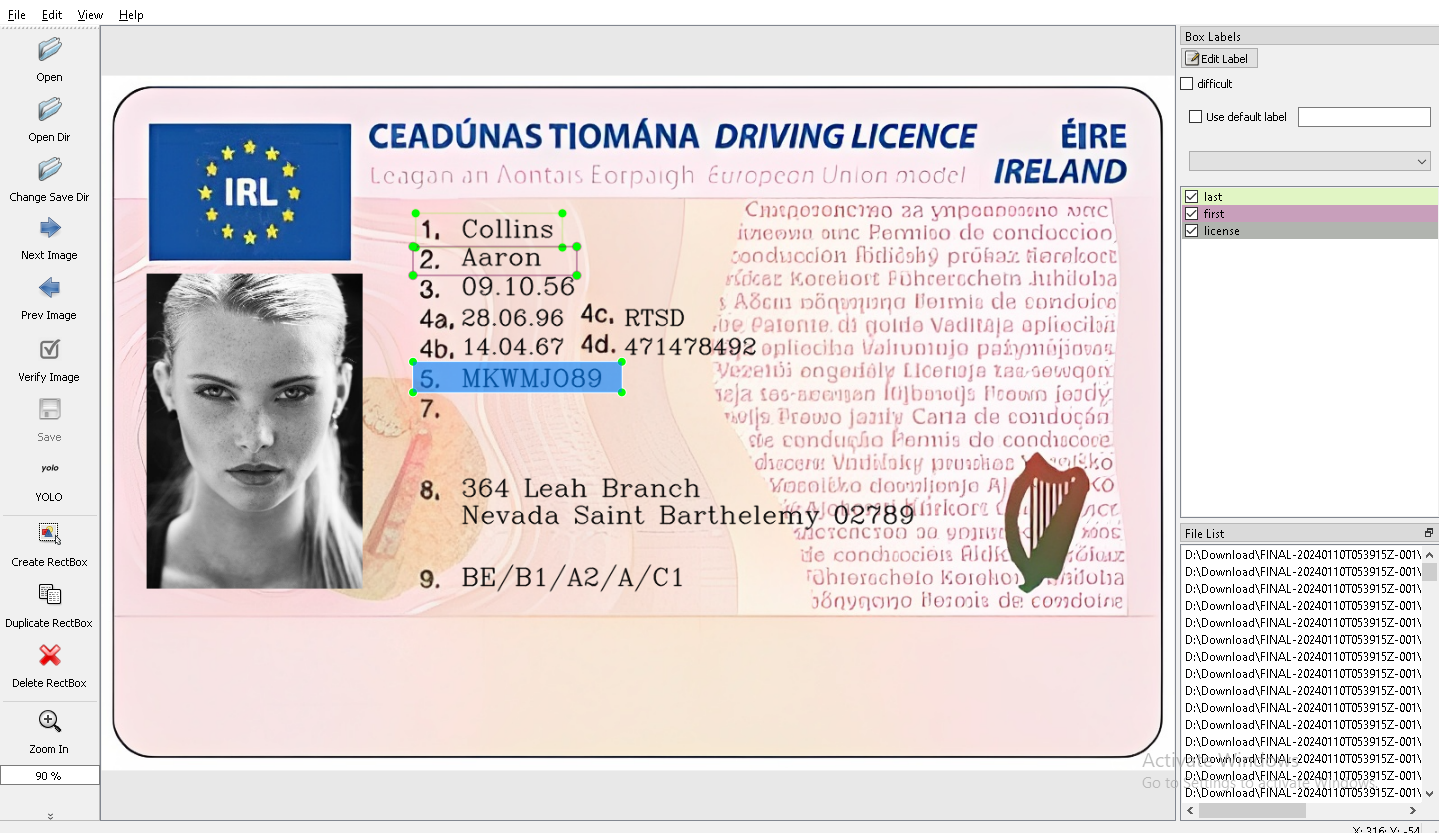
![file explorer.png](<attachment:file explorer.png>)
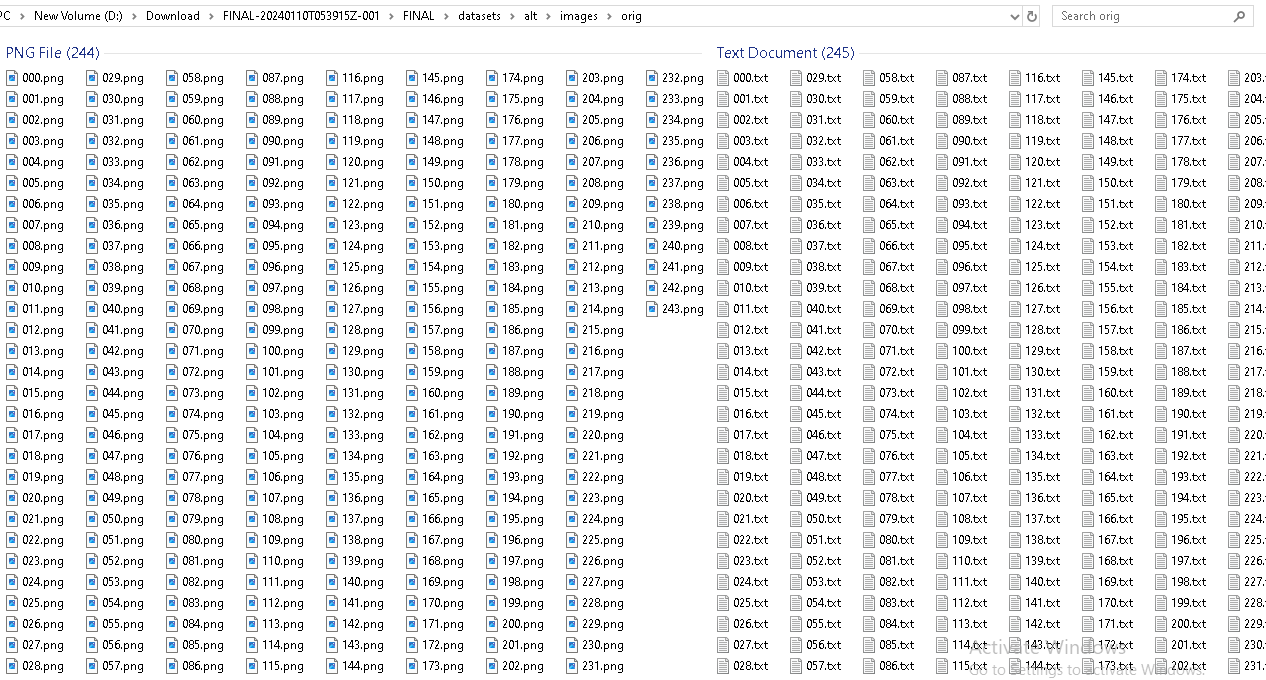

In [35]:
# Separate labels from images; training set from validation set
source_path = "datasets/alt/images/orig"
os.makedirs("datasets/alt/images/preprocess", exist_ok=True)
os.makedirs("datasets/alt/images/val", exist_ok=True)
os.makedirs("datasets/alt/labels/train", exist_ok=True)
os.makedirs("datasets/alt/labels/val" , exist_ok=True)
count = 0

for filename in os.listdir(source_path):
    jpg_path = "datasets/alt/images/train" if count<400 else "datasets/alt/images/val"     # first 200 img for training
    txt_path = "datasets/alt/labels/train" if count<400 else "datasets/alt/labels/val"     # first 200 txt for training
    file = os.path.join(source_path, filename)

    if filename.endswith('.png'):
        shutil.move(file, os.path.join(jpg_path, filename))         # move img file

    else:
        base, extension = os.path.splitext(os.path.basename(filename))

        if base == "classes":
            shutil.move(file, "datasets/alt/labels")                # move classes.txt in labels folder
        else:
            shutil.move(file, os.path.join(txt_path, filename))     # move txt file
    
    count += 1

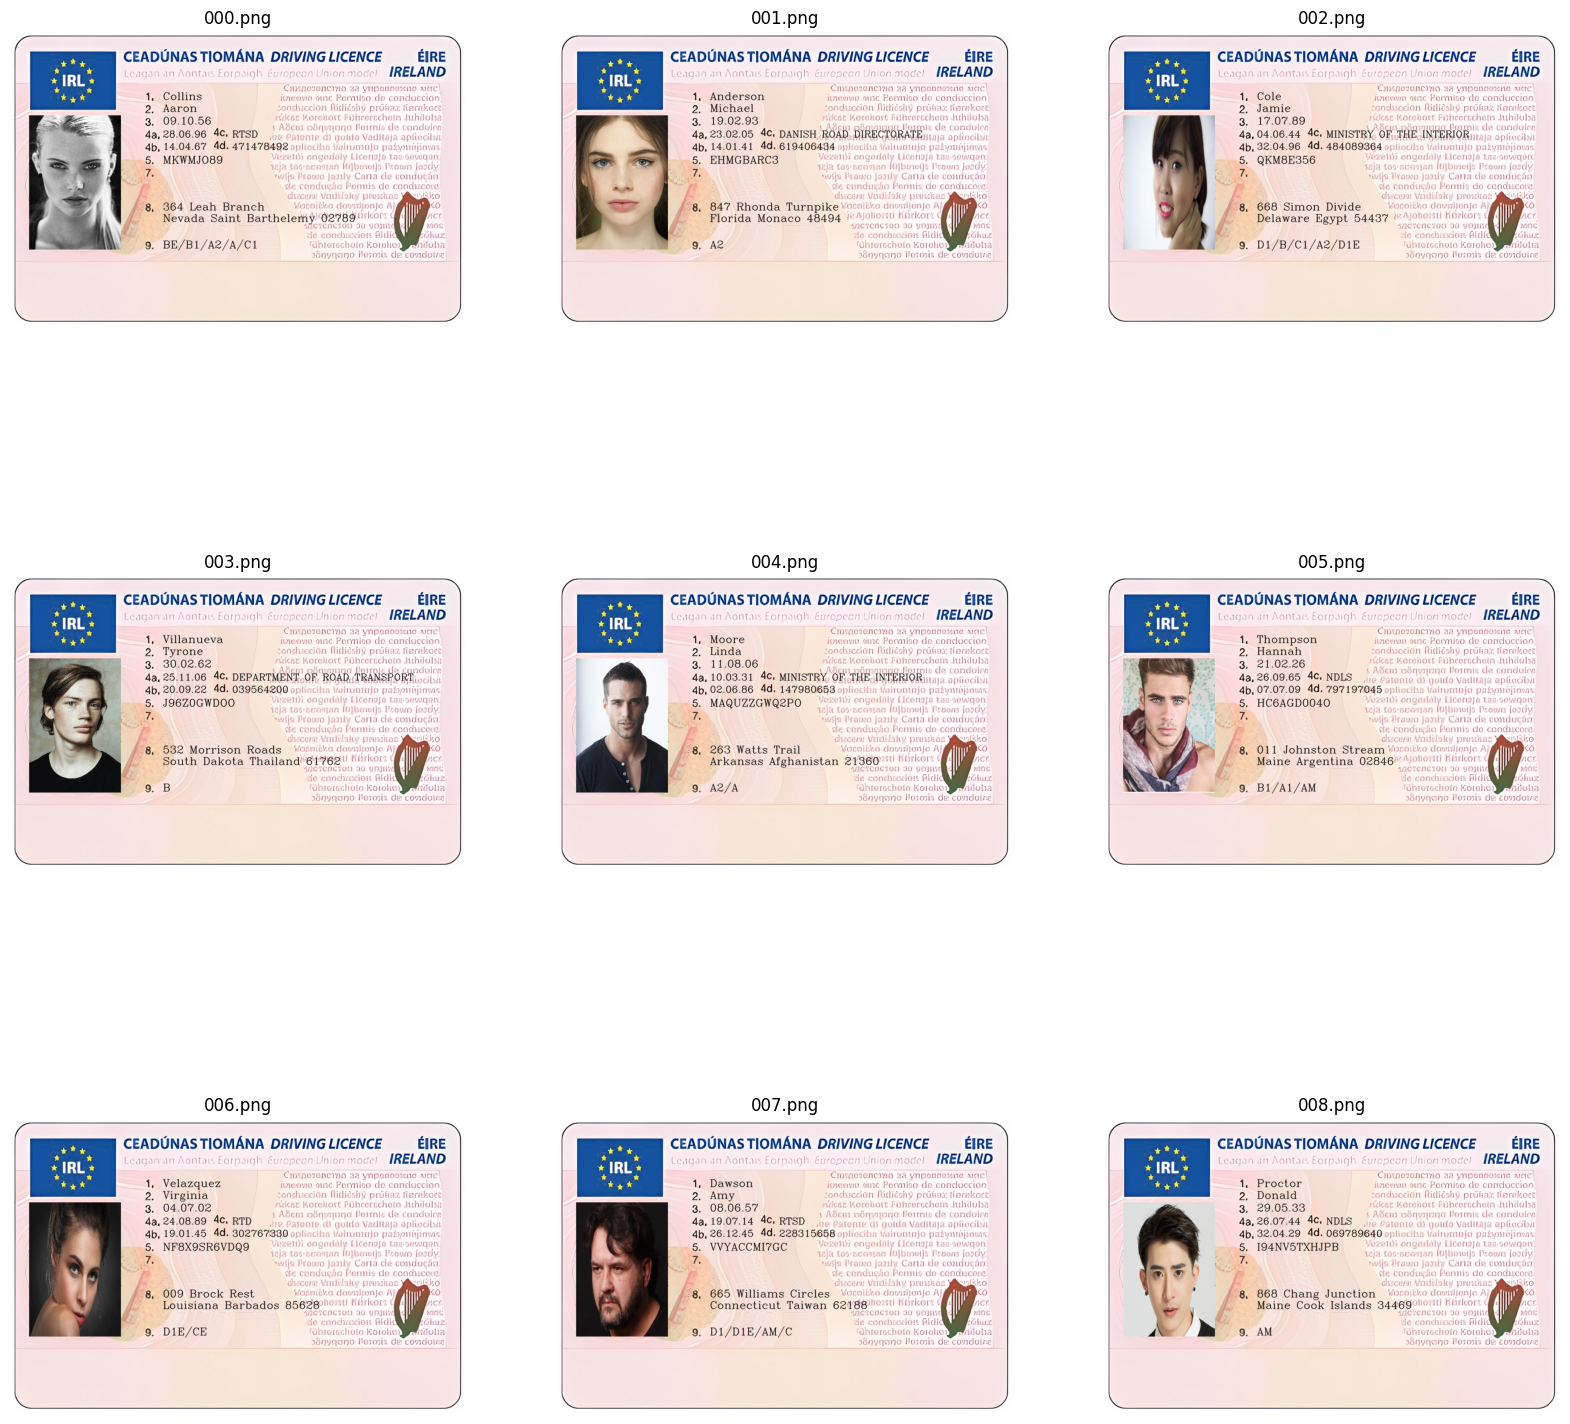

In [46]:
# Display original training set
source_path = "datasets/alt/images/preprocess"
count = 0
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()

for filename in os.listdir(source_path):
    if count > 8:
        break

    image = Image.open(os.path.join(source_path, filename))
    axs[count].imshow(image)
    axs[count].axis('off')
    axs[count].set_title(f'{filename}')
    count += 1
    
plt.show()

In [49]:
# NOT INCLUDED

# # Preprocessing training set images
# train_path = "datasets/alt/images/train"
# os.makedirs(train_path, exist_ok=True)

# for filename in os.listdir(source_path):
#     base, extension = os.path.splitext(os.path.basename(filename))
#     image = Image.open(os.path.join(source_path, filename)) 
#     gs_img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
#     thres_img = cv2.threshold(gs_img, 0, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#     # Maintain filename as original 
#     # NOTE: IMG filename must be same as LABEL filename
#     if count < 10:
#         name = f'00{count}'
#     elif (count >= 10) and (count < 99):
#         name = f'0{count}'
#     else:
#         name = count

#     cv2.imwrite(f'{train_path}/{filename}', thres_img)

In [ ]:
# NOT INCLUDED

# # Display preprocessed training set
# source_path = "datasets/alt/images/train"
# count = 0
# fig, axs = plt.subplots(3, 3, figsize=(20, 20))
# axs = axs.flatten()

# for filename in os.listdir(source_path):
#     if count > 8:
#         break

#     image = (Image.open(os.path.join(source_path, filename))).convert("RGB")    # CV2 uses BGR; PIL uses RGB
#     axs[count].imshow(image)
#     axs[count].axis('off')
#     axs[count].set_title(f'{filename}')
#     count += 1
    
# plt.show()

## __2. Select & train YOLOv8 model__ 
Select a model from YOLOv8, each containing pre-initialized weights for training/fine-tuning. __YOLOv8n__ will be used for this scenario due to its faster training speed, compared to other models.

In [ ]:
# Run this command in terminal for model training (provided by YOLOv8)
!yolo task=detect mode=train model=yolov8n.pt data=config.yaml epochs=50

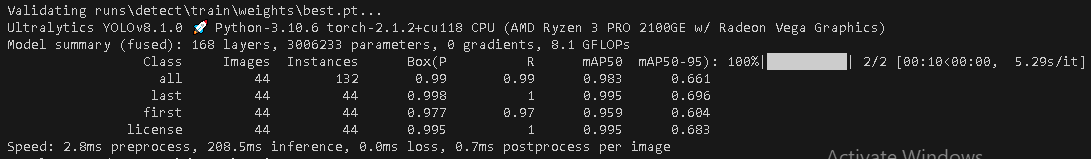

__Results:__

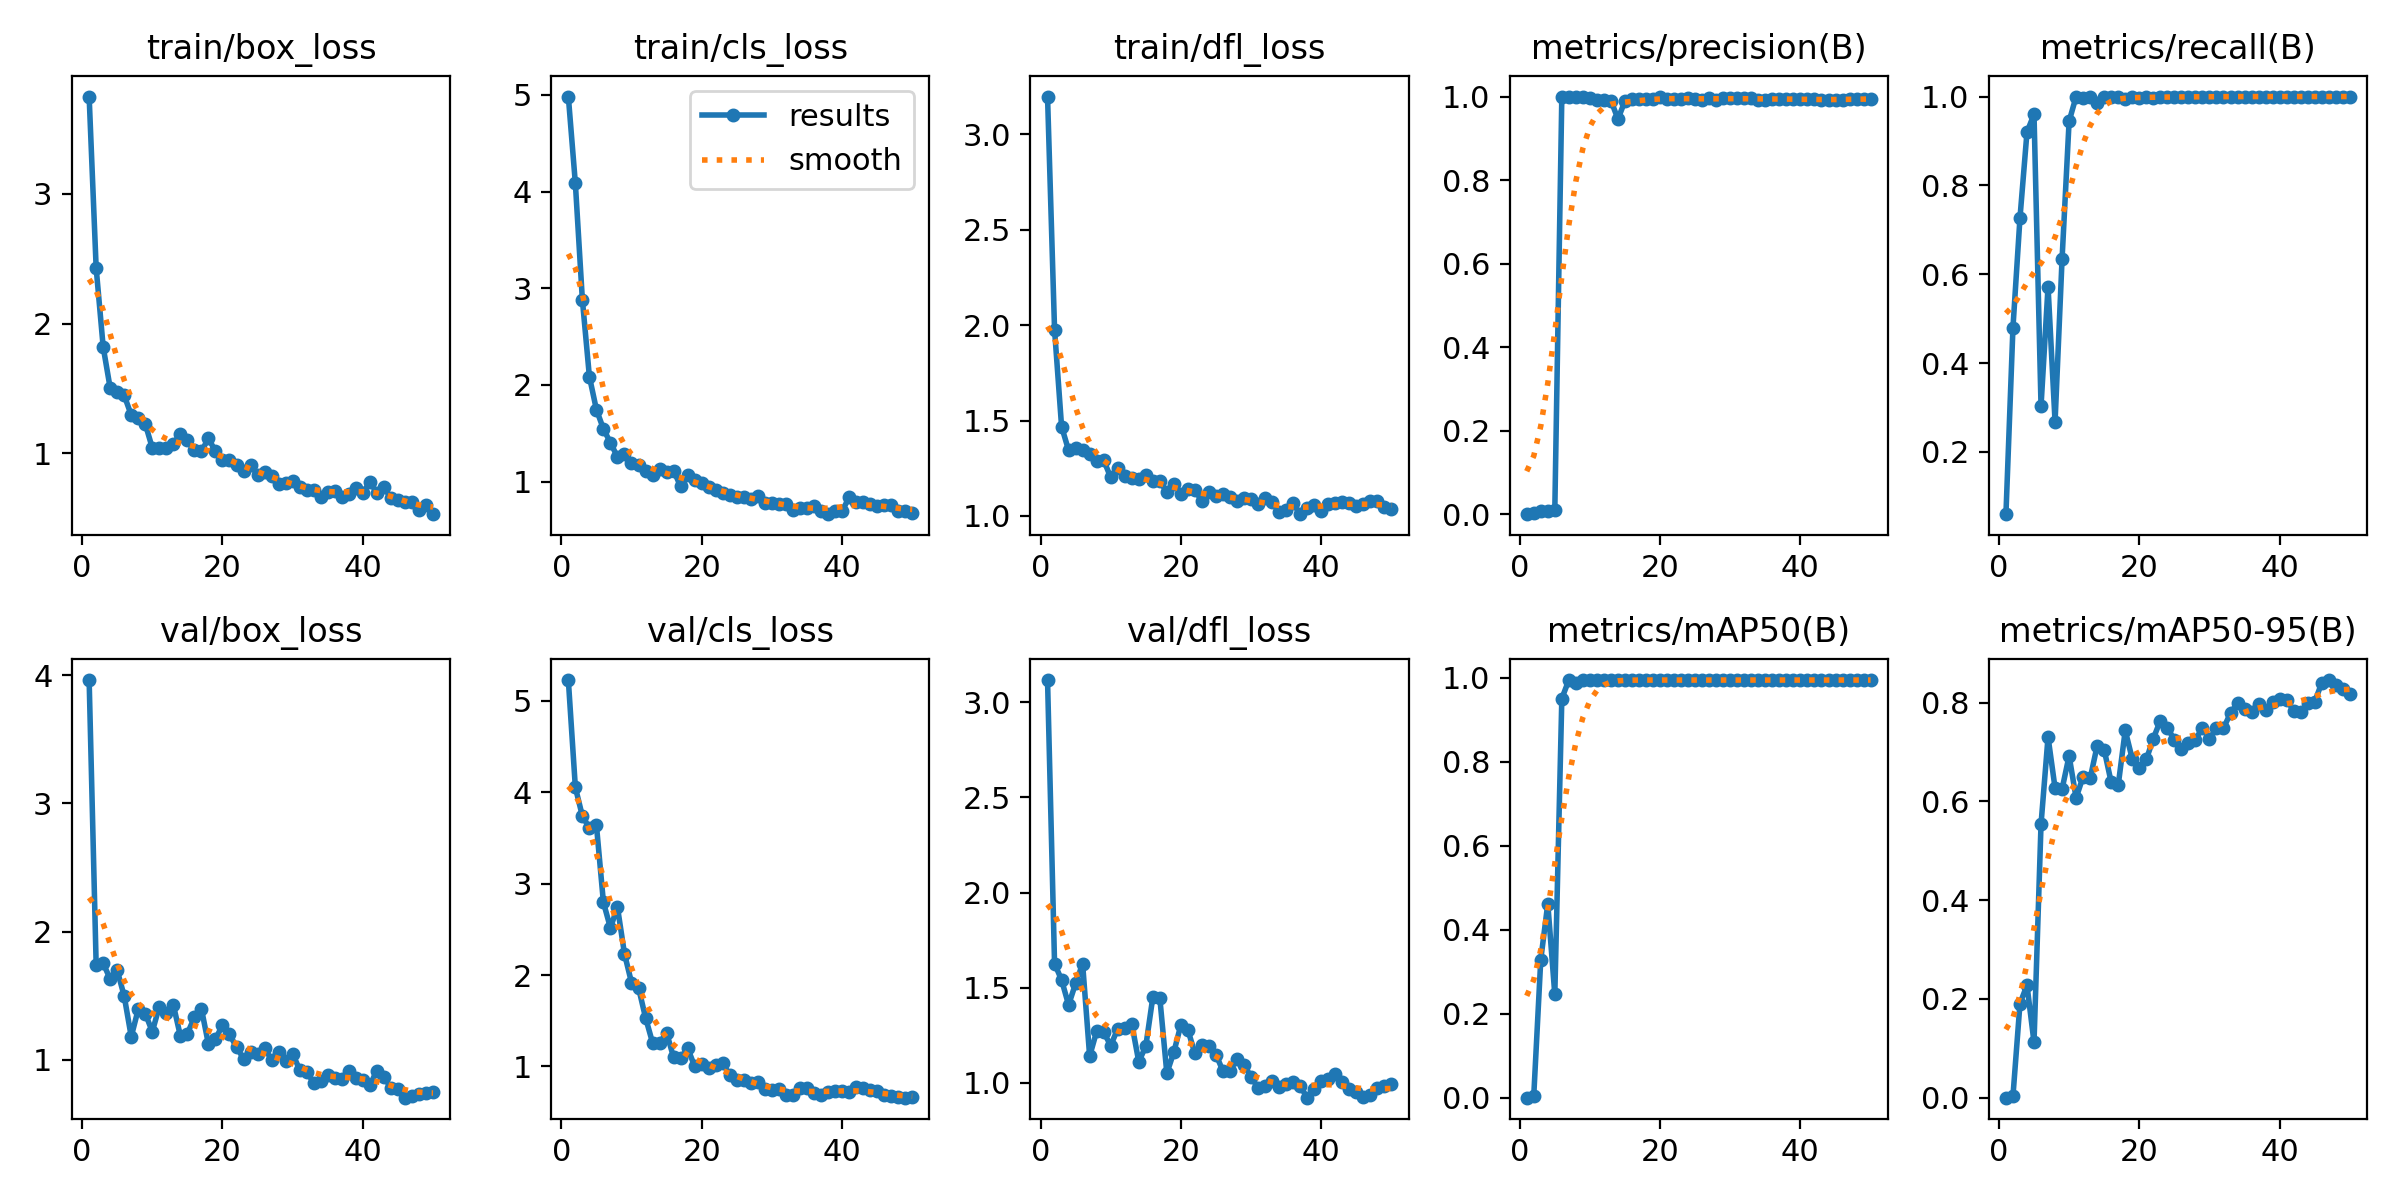

__Precision-Confidence Curve:__

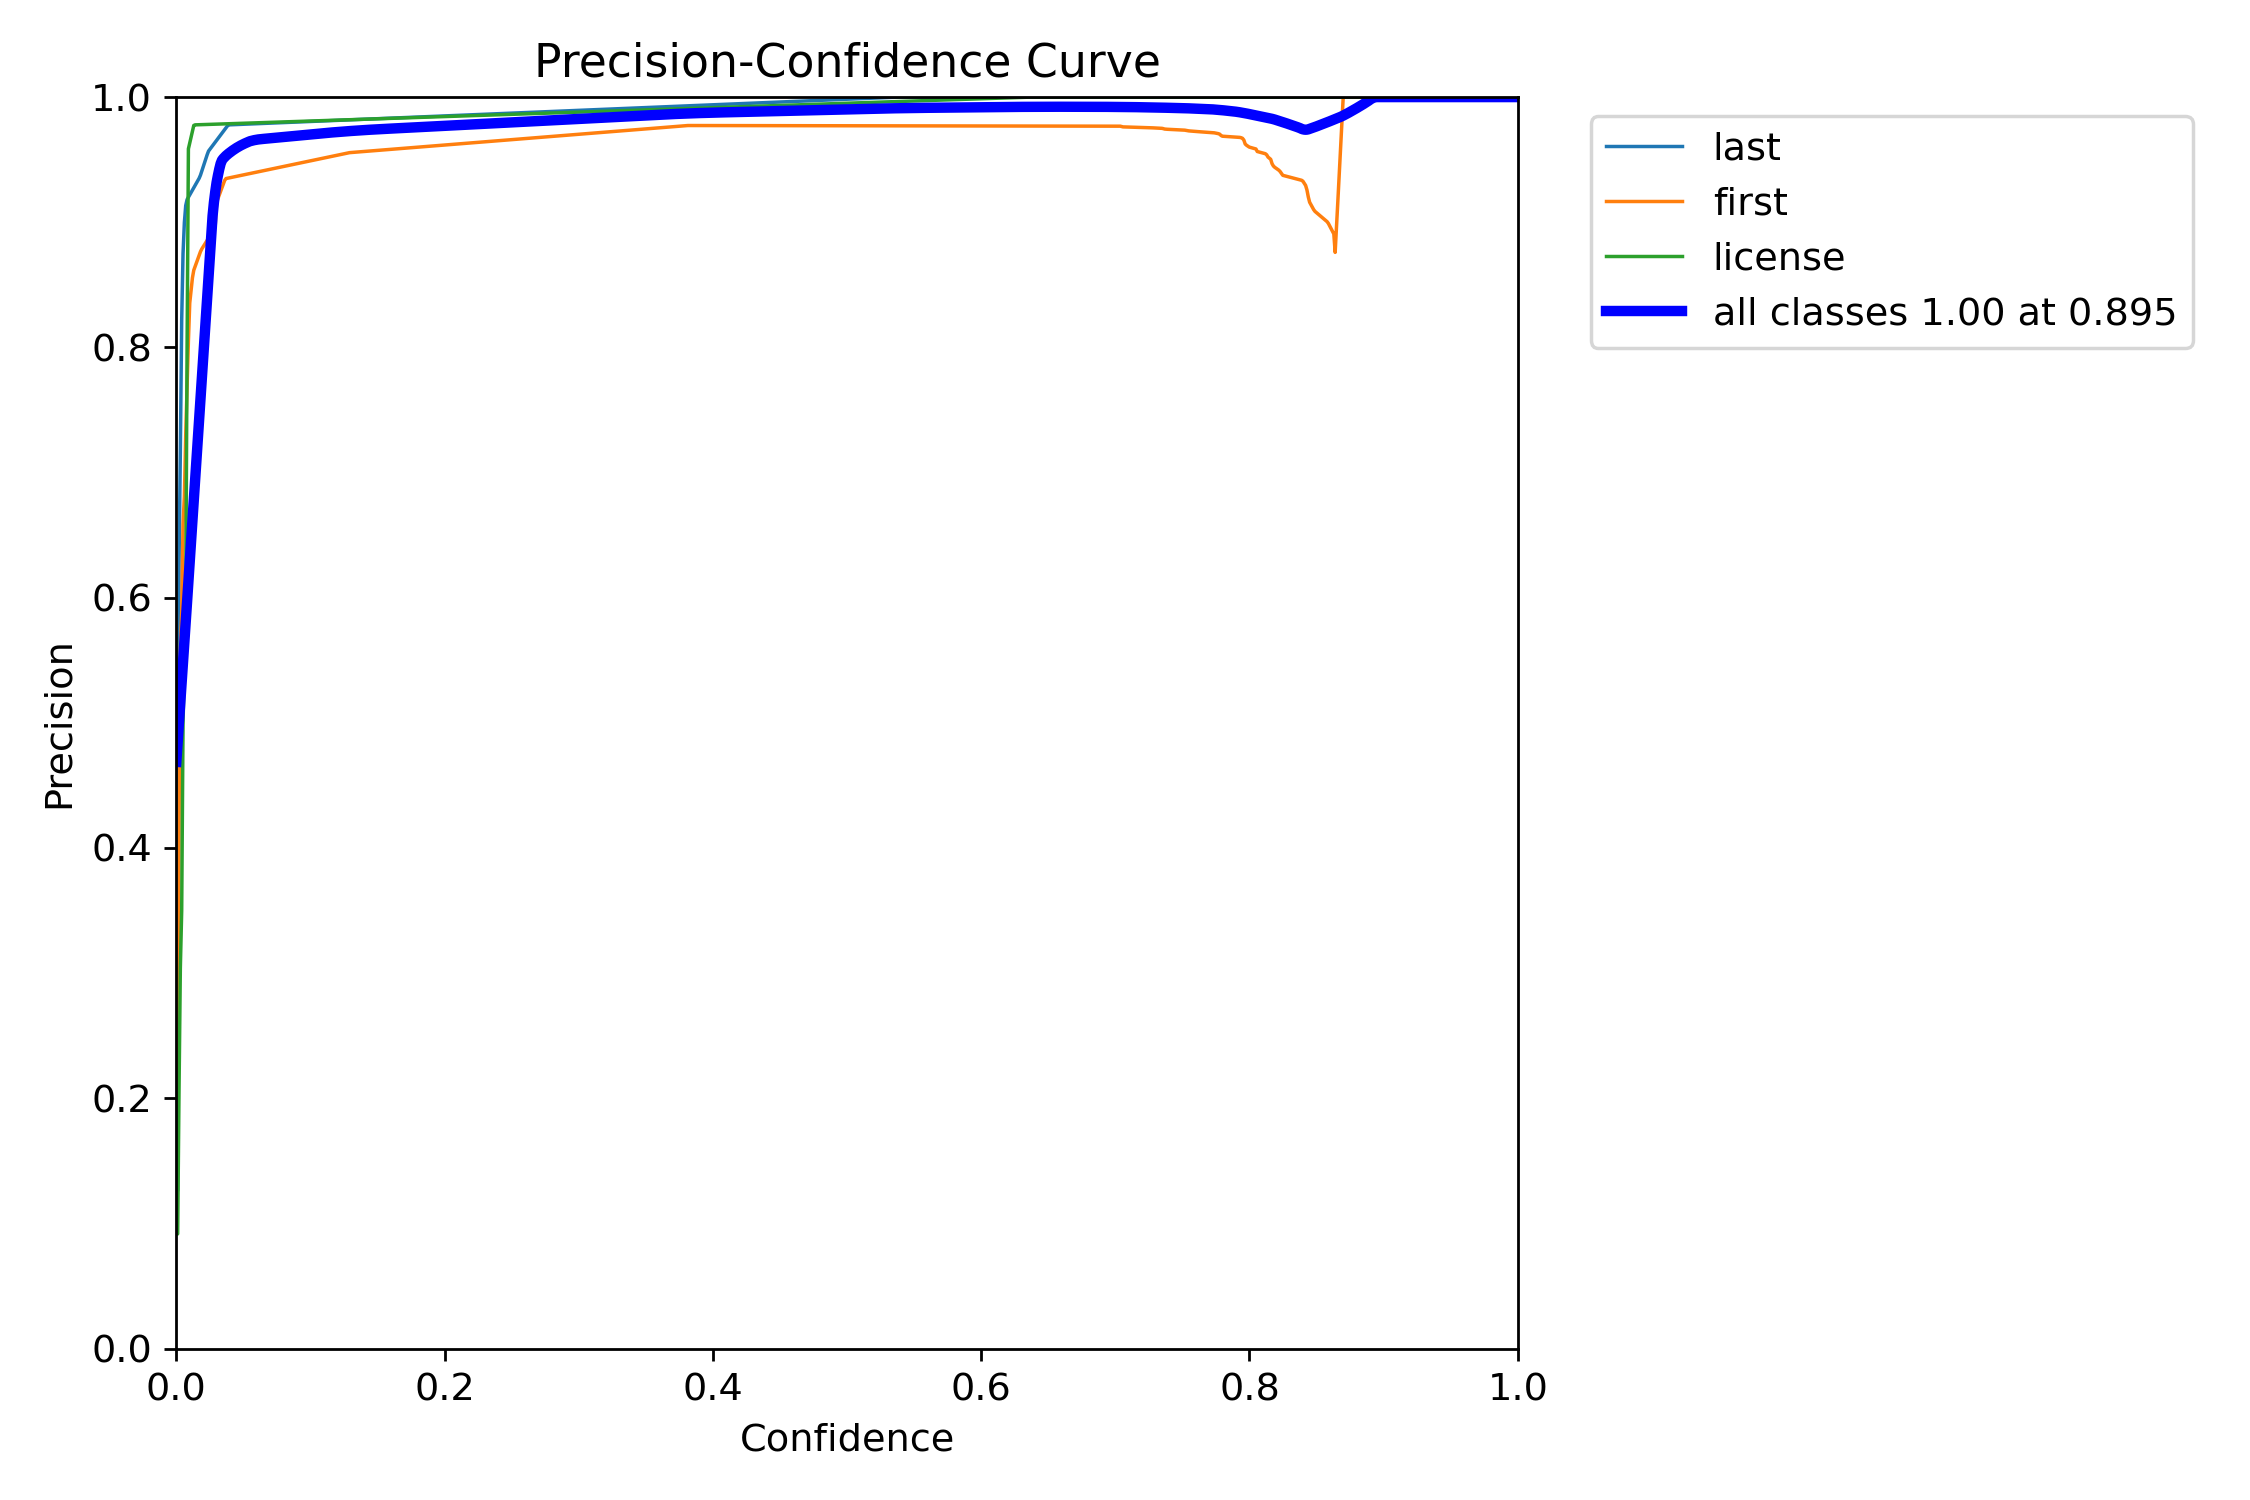

__Precision-Recall Curve:__

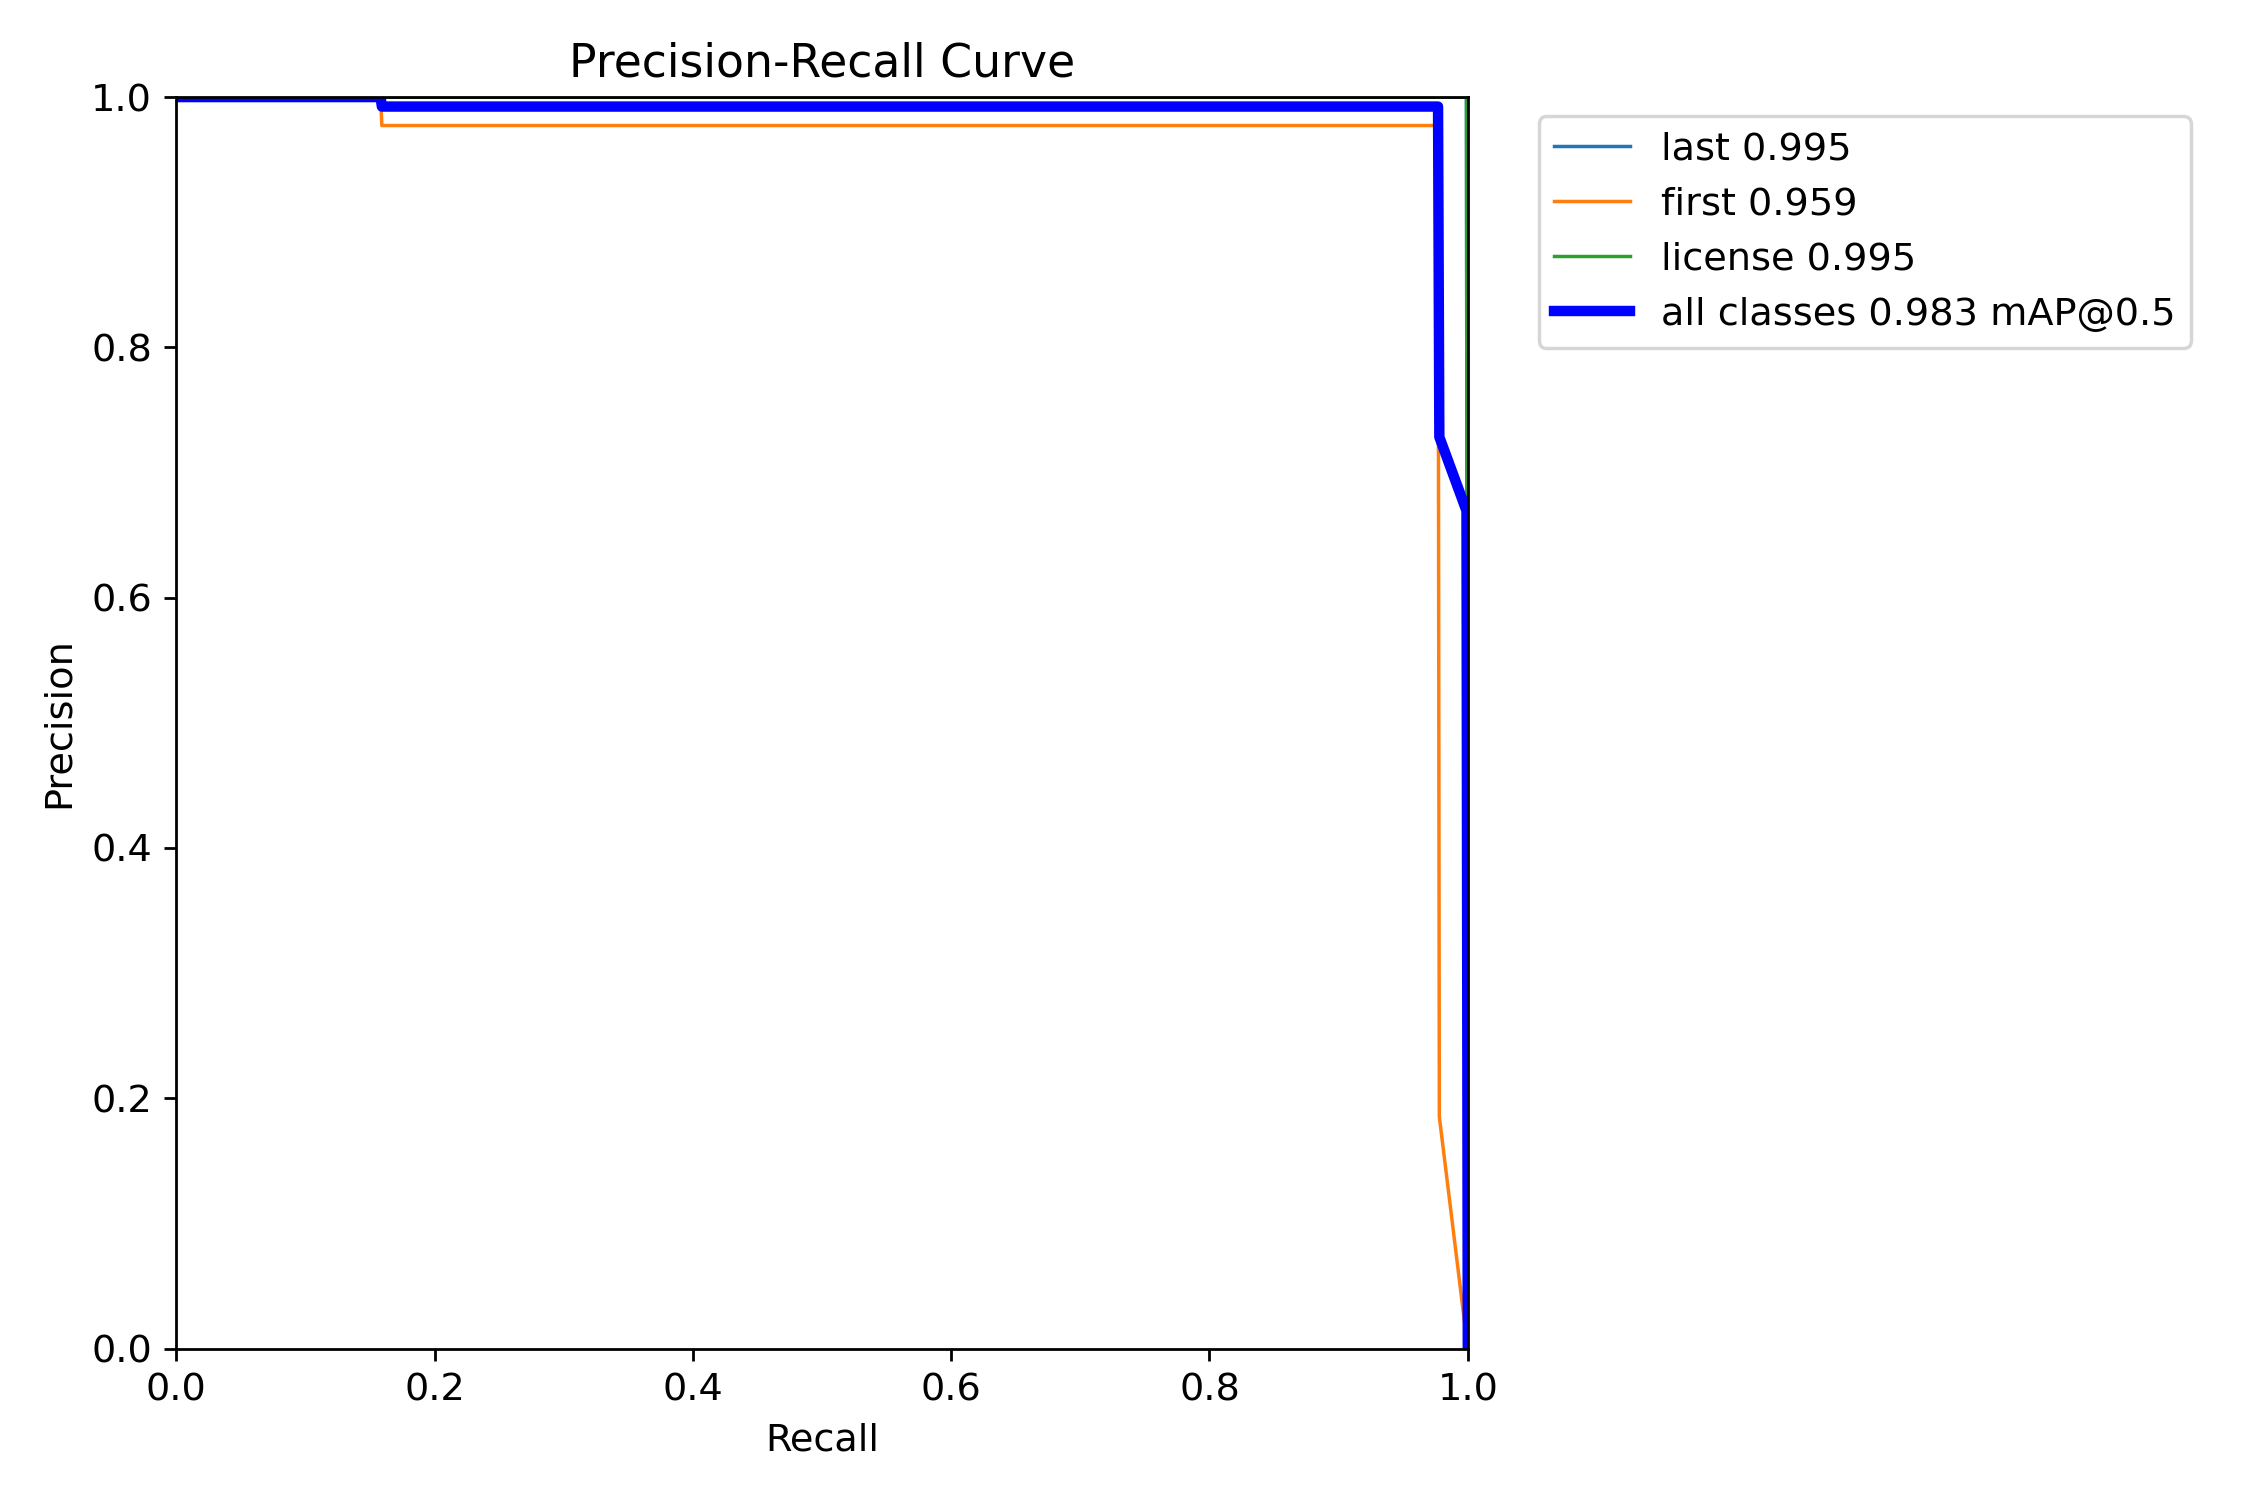

## __3. Inferencing trained custom model__
After training, test trained model by inferencing sample image. Crop and save detected objects for data extraction.

In [52]:
# Run command for inferencing (provided by YOLOv8)
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt source=datasets/alt/images/inf show=True show_labels=True save_crop

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()
OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'

Ultralytics YOLOv8.1.0 🚀 Python-3.10.6 torch-2.1.2+cu118 CPU (AMD Ryzen 3 PRO 2100GE w/ Radeon Vega Graphics)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs

image 1/44 D:\Download\FINAL-20240110T053915Z-001\FINAL\datasets\alt\images\inf\generated_license_2191.png: 416x640 1 last, 1 first, 1 license, 237.5ms
image 2/44 D:\Download\FINAL-20240110T053915Z-001\FINAL\datasets\alt\images\inf\generated_license_2192.png: 416x640 1 last, 1 first, 1 license, 227.4ms
image 3/44 D:\Download\FINAL-20240110T053915Z-001\FINAL\datasets\alt\images\inf\gen

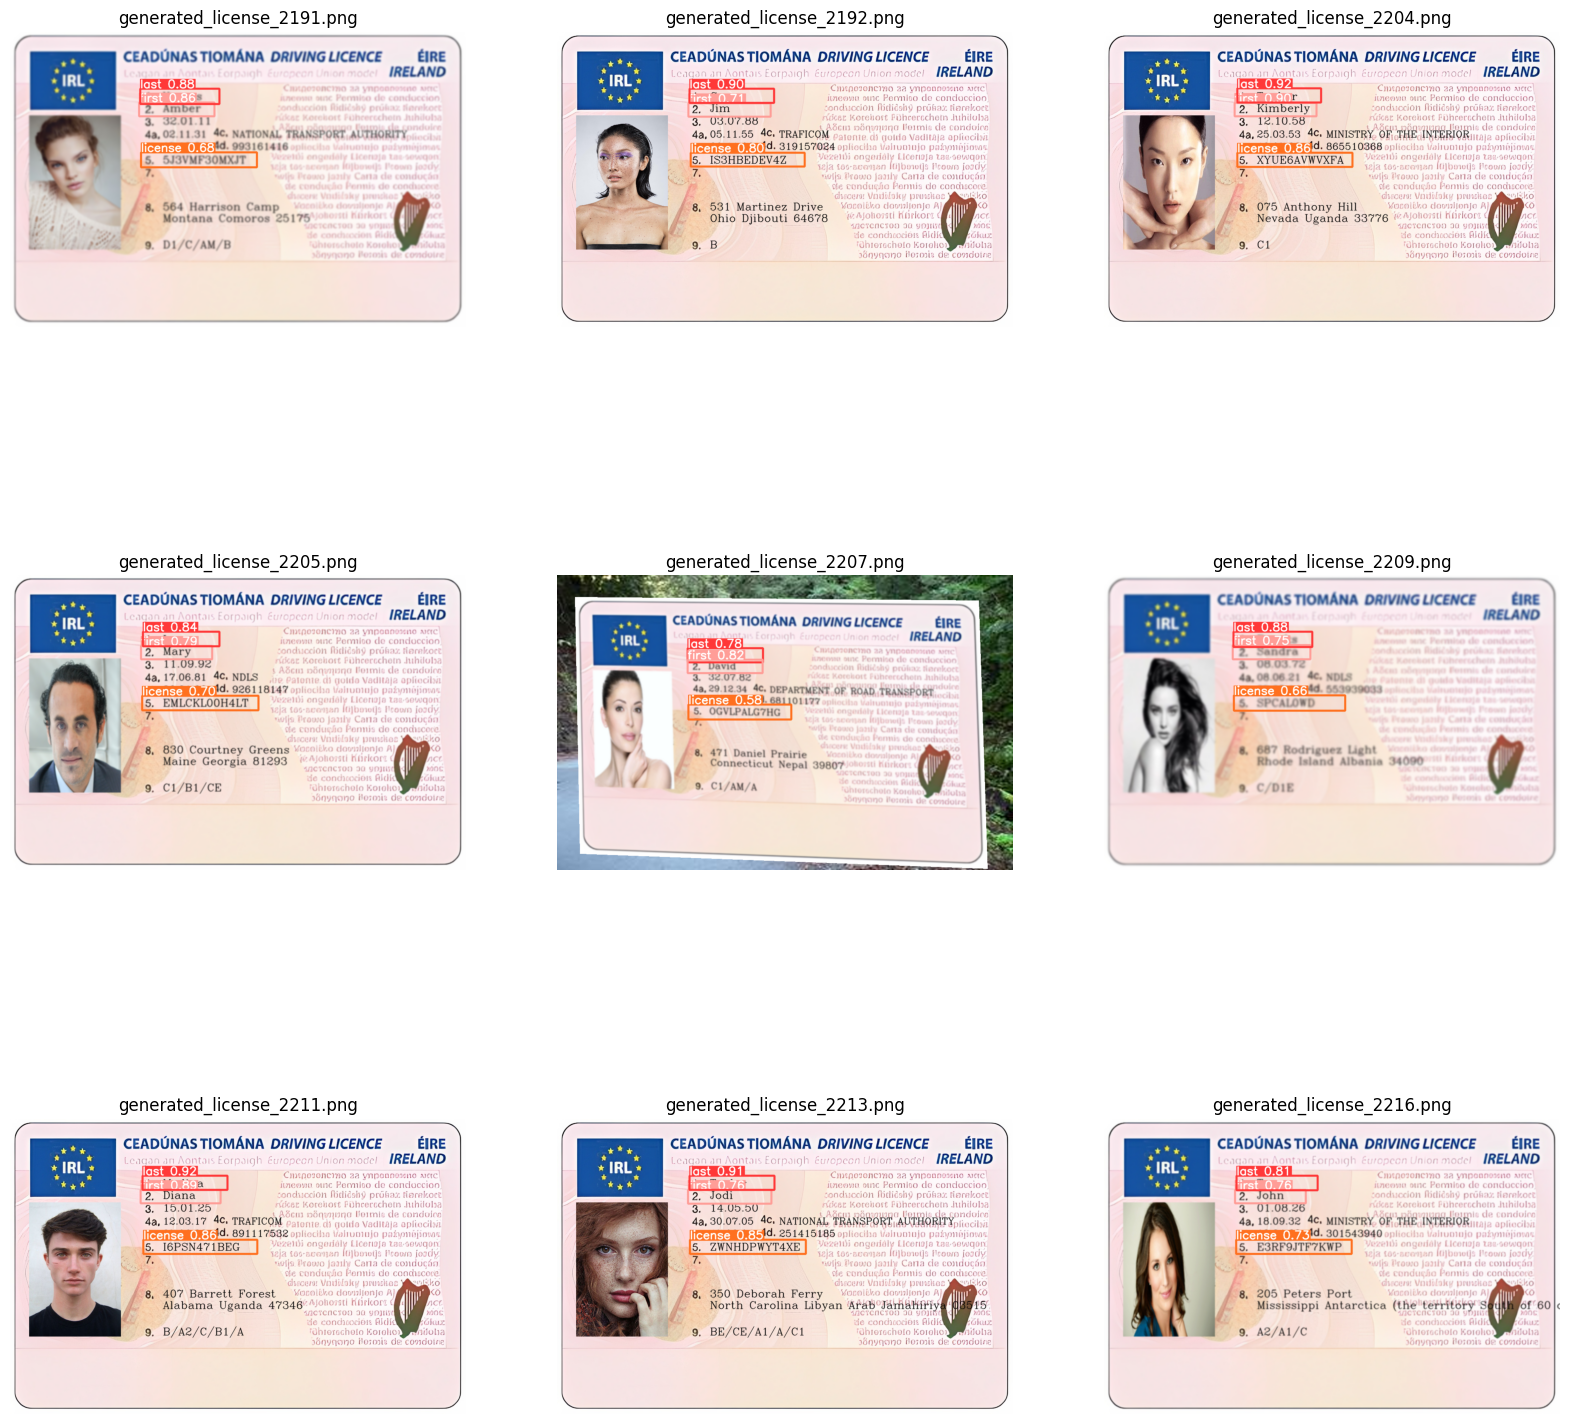

In [57]:
# Inferences
source_path = "runs\detect\predict"
count = 0
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()

def png_files(file_path, extension):
    files = [x for x in os.listdir(file_path) if x.endswith(extension)]
    return files

for filename in png_files(source_path, '.png'):
    if count > 8:
        break

    image = Image.open(os.path.join(source_path, filename))
    axs[count].imshow(image)
    axs[count].axis('off')
    axs[count].set_title(f'{filename}')
    count += 1
    
plt.show()

## 5. Extract data using OCR
Using a pretrained __EasyOCR__ model, extract the data from detected objects in the driver's license.

In [59]:
# Acquire all images from crops folder
root_folder = "runs/detect/predict/crops"
image_files = []
for root, dirs, files in os.walk(root_folder):
    for filename in files:
        # Check if the file has an image extension
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            # Construct the absolute path of the image file
            image_files.append(os.path.join(root, filename))

image_files


['runs/detect/predict/crops\\first\\generated_license_2191.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2192.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2204.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2205.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2207.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2209.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2211.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2213.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2216.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2219.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2220.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2222.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2223.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2225.jpg',
 'runs/detect/predict/crops\\first\\generated_license_2226.jpg',
 'runs/detect/predict/cro

Using CPU. Note: This module is much faster with a GPU.


Text(0.5, 1.0, 'OCR Inference Result')

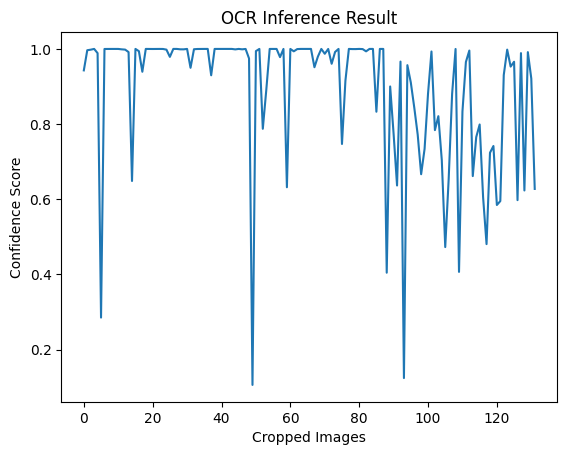

In [76]:
# Extract data using EasyOCR
reader = easyocr.Reader(['en'], gpu = False)
count = 0
x_list = []
y_list = []

for x in image_files:
    result = reader.readtext(x)
    y_list.append(result[1][2] if (len(result) > 1) else result[0][2])
    x_list.append(count)
    # print(pd.DataFrame(result, columns=['bbox','text','conf']))
    # print(result)
    count += 1

plt.plot(x_list, y_list)
plt.xlabel('Cropped Images')
plt.ylabel('Confidence Score')
plt.title('OCR Inference Result')